# Exploratory Data Analysis

In [32]:
if (!require("car")) install.packages("DBI")
if (!require("tibble")) install.packages("ggplot2")
if (!require("dplyr")) install.packages("RSQLite")
if (!require("car")) install.packages("DBI")
if (!require("tibble")) install.packages("lubridate")
if (!require("dplyr")) install.packages("pastecs")
if (!require("car")) install.packages("car")
if (!require("tibble")) install.packages("tibble")
if (!require("dplyr")) install.packages("dplyr")
if (!require("RColorBrewer")) install.packages("RColorBrewer")
if (!require("corrplot")) install.packages("corrplot")
if(!require(corrplot)) {install.packages("corrplot");require(corrplot)}
if (!require("VIM")) {install.packages("VIM");require(VIM)} 

Loading required package: VIM

Loading required package: colorspace

Loading required package: grid

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:pastecs':

    first, last


The following objects are masked from 'package:dplyr':

    between, first, last


VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.


Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:datasets':

    sleep




In [2]:
library(DBI)
library(dplyr)
library(pastecs)
library(ggplot2)
library(lubridate)
library(RSQLite)



Attaching package: 'pastecs'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date




In [3]:
###########################
## Mechkar installation ###
###########################

library(devtools)
#install_github("karpatit/mechkar")
library(mechkar)
setwd("C:/Users/michs/Documents/DataScience/stats/")

Loading required package: usethis



In [4]:
con <- dbConnect(odbc::odbc(), .connection_string = "DSN=BoxOffice;Trusted_Connection=yes;", timeout = 10)

In [ ]:
movies_ff <- dbReadTable(con,"movies_ff_v")

In [33]:
save(movies_ff,file="C:/Users/michs/Documents/DataScience/data/BoxOffice_ff.RData")

In [5]:
load("C:/Users/michs/Documents/DataScience/data/BoxOffice_ff.RData")

In [60]:
###############################################################################
##############################################################################
vn <- names(movies_ff[,2:84])
movies_numeric <- c('movie_id')
for(v in vn) {
        if((is.numeric(movies_ff[[v]])) & (max(movies_ff[[v]],na.rm=T)>1))
            {movies_numeric <- c(movies_numeric,v)}}

##############################################################################

In [6]:
#########################################################################
#############------Functions misings and outliers--------################
#########################################################################

outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

# 2.1 - Data stats

In [51]:
summary(movies_ff)

    movie_id        budget          original_language    popularity 
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  4  
 Median :3696   Median :  8000000   Mode  :character   Median :  7  
 Mean   :3698   Mean   : 22666657                      Mean   :  9  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 11  
 Max.   :7398   Max.   :380000000                      Max.   :547  
                                                                    
 release_date          runtime    runtime_cat           revenue          
 Length:7375        Min.   :  0   Length:7375        Min.   :         1  
 Class :character   1st Qu.: 94   Class :character   1st Qu.:   2405420  
 Mode  :character   Median :104   Mode  :character   Median :  16928137  
                    Mean   :108                      Mean   :  66879312  
                    3rd Qu.:118                      3rd Qu.:  69055695  
    

In [5]:

library(pastecs)
options(scipen=100)
options(digits=2)
stat.desc(movies_ff[,6:84], basic=TRUE, desc=TRUE, norm=FALSE, p=0.95)

,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,release_year,release_month,...,depart_Art_female,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female
nbr.val,7370.00,NA,2993.0,7375.0000,7375.0000,7375.00000,7375.0000,7375.000,7374.0000,7374.000,...,7341.0000,7341.0000,7341.0000,7341.0000,7341.0000,7341.0000,7341.00000,7341.000,7341.0000,7341.0000
nbr.null,19.00,NA,0.0,1039.0000,5012.0000,2.00000,1442.0000,649.000,0.0000,0.000,...,5988.0000,7194.0000,6971.0000,5293.0000,6297.0000,6516.0000,7336.00000,3872.000,6840.0000,7281.0000
nbr.na,5.00,NA,4382.0,0.0000,0.0000,0.00000,0.0000,0.000,1.0000,1.000,...,34.0000,34.0000,34.0000,34.0000,34.0000,34.0000,34.00000,34.000,34.0000,34.0000
min,0.00,NA,1.0,0.0000,0.0000,0.00000,0.0000,0.000,1918.0000,1.000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.000,0.0000,0.0000
max,338.00,NA,1519557910.0,1.0000,1.0000,1.00000,1.0000,149.000,2017.0000,12.000,...,7.0000,3.0000,10.0000,6.0000,4.0000,5.0000,1.00000,12.000,6.0000,2.0000
range,338.00,NA,1519557909.0,1.0000,1.0000,1.00000,1.0000,149.000,99.0000,11.000,...,7.0000,3.0000,10.0000,6.0000,4.0000,5.0000,1.00000,12.000,6.0000,2.0000
sum,794097.00,NA,200169779760.0,6336.0000,2363.0000,7373.00000,5933.0000,53579.000,14745625.0000,50471.000,...,1726.0000,150.0000,473.0000,2595.0000,1127.0000,893.0000,5.00000,6898.000,581.0000,62.0000
median,104.00,NA,16928137.0,1.0000,0.0000,1.00000,1.0000,6.000,2004.0000,7.000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000,0.000,0.0000,0.0000
mean,107.75,NA,66879311.6,0.8591,0.3204,0.99973,0.8045,7.265,1999.6779,6.844,...,0.2351,0.0204,0.0644,0.3535,0.1535,0.1216,0.00068,0.940,0.0791,0.0084
SE.mean,0.25,NA,2516188.3,0.0041,0.0054,0.00019,0.0046,0.073,0.1790,0.039,...,0.0065,0.0017,0.0039,0.0076,0.0046,0.0042,0.00030,0.016,0.0037,0.0011


In [26]:
#####counting unique#####

rapply(movies_ff,function(x)length(unique(x)))

movie_id                       budget 
                        7375                          704 
           original_language                   popularity 
                          44                         7371 
                release_date                      runtime 
                        4697                          168 
                 runtime_cat                      revenue 
                           3                         2845 
                  sw_lang_en              sw_web_presence 
                           2                            2 
               sw_has_poster                   sw_tagline 
                           2                            2 
                 keyword_cnt                 release_year 
                          46                           99 
               release_month           high_release_month 
                          13                            2 
                 release_day                  seasonality 
                          32                           13 
               sw_collection                producers_cnt 
                           3                           25 
               countries_cnt                      lang_US 
                          12                            2 
                     lang_FR                      lang_RU 
                           2                            2 
                     lang_ES                      lang_JA 
                           2                            2 
                keywords_cnt            actor0_movies_cnt 
                          46                           61 
        actor0_movies_5y_cnt            actor1_movies_cnt 
                          17                           59 
        actor1_movies_5y_cnt            actor2_movies_cnt 
                          18                           53 
        actor2_movies_5y_cnt             sw_female_actor0 
                          16                            3 
            sw_female_actor1             sw_female_actor2 
                           3                            3 
              sw_male_actor0               sw_male_actor1 
                           3                            3 
              sw_male_actor2          actor0_prev_revenue 
                           3                         1152 
         actor1_prev_revenue          actor2_prev_revenue 
                        1265                         1341 
         director_movies_cnt       director_movies_5y_cnt 
                          30                            7 
             genre_adventure                genre_fantasy 
                           2                            2 
             genre_animation                  genre_drama 
                           2                            2 
                genre_horror                 genre_action 
                           2                            2 
                genre_comedy                genre_history 
                           2                            2 
               genre_western               genre_thriller 
                           2                            2 
                 genre_crime            genre_documentary 
                           2                            2 
       genre_science_fiction                genre_mystery 
                           2                            2 
                 genre_music                genre_romance 
                           2                            2 
                genre_family                    genre_war 
                           2                            2 
               genre_foreign                   depart_Art 
                           2                           35 
               depart_Camera                  depart_Crew 
                          24                           51 
          depart_Custom_Mkup             depart_Directing 
                          28                           24 
        

In [43]:
str(movies_ff)

'data.frame':	7375 obs. of  85 variables:
 $ movie_id                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ budget                      : int  14000000 40000000 3300000 1200000 0 8000000 14000000 0 0 6000000 ...
 $ original_language           : chr  "en" "en" "en" "hi" ...
 $ popularity                  : num  6.58 8.25 64.3 3.17 1.15 ...
 $ release_date                : chr  "2015-02-20" "2004-08-06" "2014-10-10" "2012-03-09" ...
 $ runtime                     : num  93 113 105 122 118 83 92 84 100 91 ...
 $ runtime_cat                 : chr  "Short" "Medium" "Medium" "Large" ...
 $ revenue                     : int  12314651 95149435 13092000 16000000 3923970 3261638 85446075 2586511 34327391 18750246 ...
 $ sw_lang_en                  : int  1 1 1 0 0 1 1 1 1 1 ...
 $ sw_web_presence             : int  0 0 1 1 0 0 1 0 0 0 ...
 $ sw_has_poster               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ sw_tagline                  : int  1 1 1 0 0 0 1 1 1 1 ...
 $ keyword_cnt                 : in

In [44]:
dim(movies_ff)

[1] 7375   85

In [45]:
names(movies_ff)

[1] "movie_id"                     "budget"                      
 [3] "original_language"            "popularity"                  
 [5] "release_date"                 "runtime"                     
 [7] "runtime_cat"                  "revenue"                     
 [9] "sw_lang_en"                   "sw_web_presence"             
[11] "sw_has_poster"                "sw_tagline"                  
[13] "keyword_cnt"                  "release_year"                
[15] "release_month"                "high_release_month"          
[17] "release_day"                  "seasonality"                 
[19] "sw_collection"                "producers_cnt"               
[21] "countries_cnt"                "lang_US"                     
[23] "lang_FR"                      "lang_RU"                     
[25] "lang_ES"                      "lang_JA"                     
[27] "keywords_cnt"                 "actor0_movies_cnt"           
[29] "actor0_movies_5y_cnt"         "actor1_movies_cnt"           
[31] "actor1_movies_5y_cnt"         "actor2_movies_cnt"           
[33] "actor2_movies_5y_cnt"         "sw_female_actor0"            
[35] "sw_female_actor1"             "sw_female_actor2"            
[37] "sw_male_actor0"               "sw_male_actor1"              
[39] "sw_male_actor2"               "actor0_prev_revenue"         
[41] "actor1_prev_revenue"          "actor2_prev_revenue"         
[43] "director_movies_cnt"          "director_movies_5y_cnt"      
[45] "genre_adventure"              "genre_fantasy"               
[47] "genre_animation"              "genre_drama"                 
[49] "genre_horror"                 "genre_action"                
[51] "genre_comedy"                 "genre_history"               
[53] "genre_western"                "genre_thriller"              
[55] "genre_crime"                  "genre_documentary"           
[57] "genre_science_fiction"        "genre_mystery"               
[59] "genre_music"                  "genre_romance"               
[61] "genre_family"                 "genre_war"                   
[63] "genre_foreign"                "depart_Art"                  
[65] "depart_Camera"                "depart_Crew"                 
[67] "depart_Custom_Mkup"           "depart_Directing"            
[69] "depart_Editing"               "depart_Lighting"             
[71] "depart_Production"            "depart_Sound"                
[73] "depart_Visual_Effects"        "depart_Writing"              
[75] "depart_Art_female"            "depart_Camera_female"        
[77] "depart_Crew_female"           "depart_Custom_Mkup_female"   
[79] "depart_Directing_female"      "depart_Editing_female"       
[81] "depart_Lighting_female"       "depart_Production_female"    
[83] "depart_Sound_female"          "depart_Visual_Effects_female"
[85] "depart_Writing_female"

# 2.2 Plots

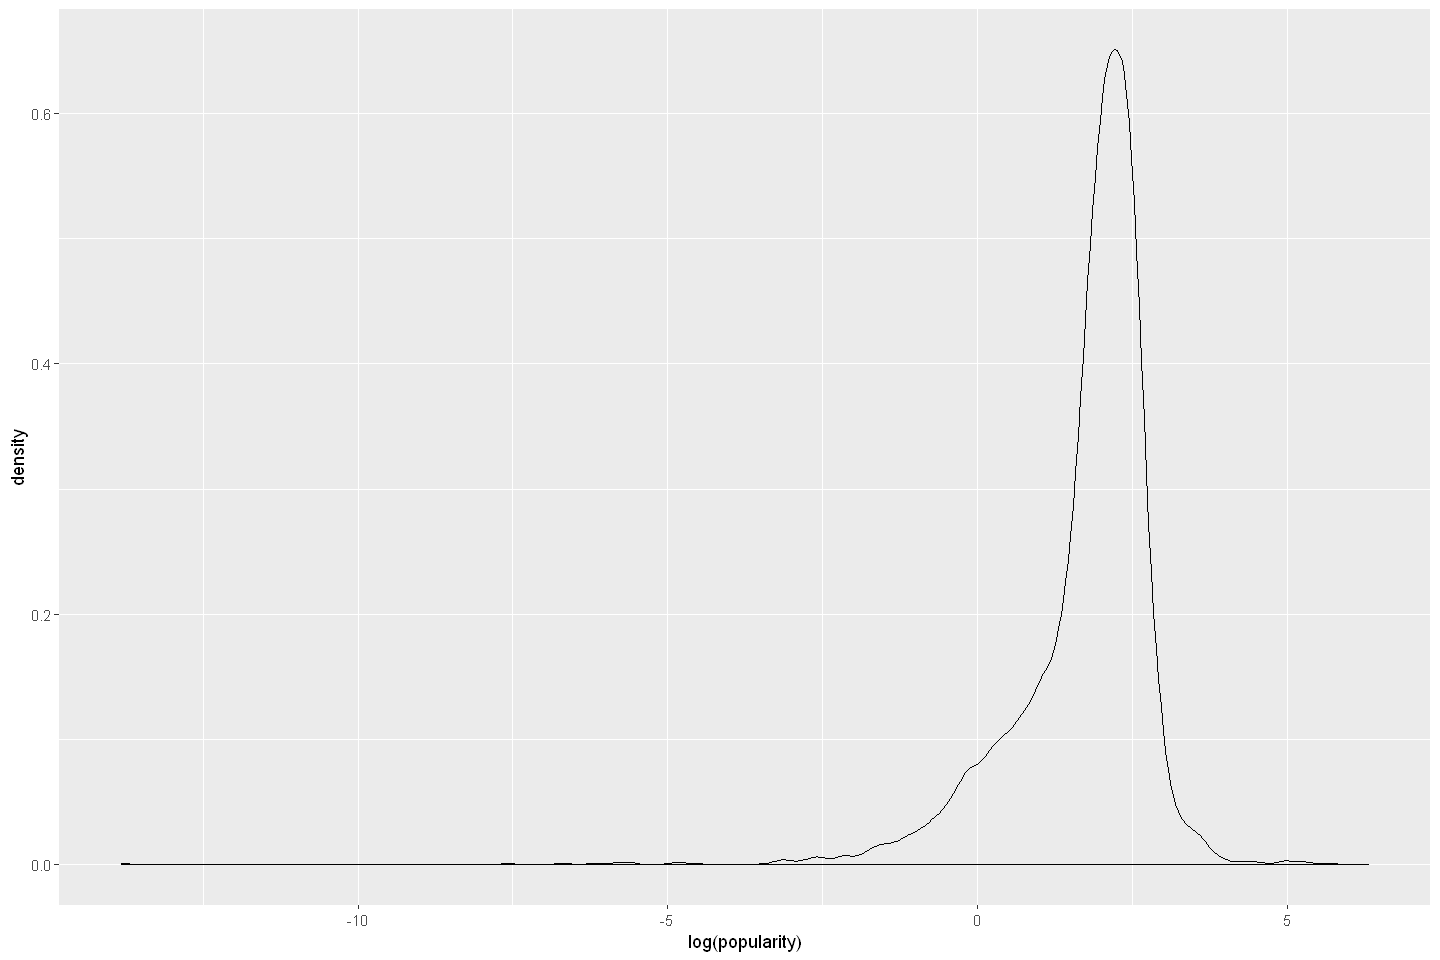

In [38]:
#popularity
options(repr.plot.width=12,repr.plot.height=8)
ggplot(data=movies_ff) +
    geom_density(aes(x = log(popularity)))

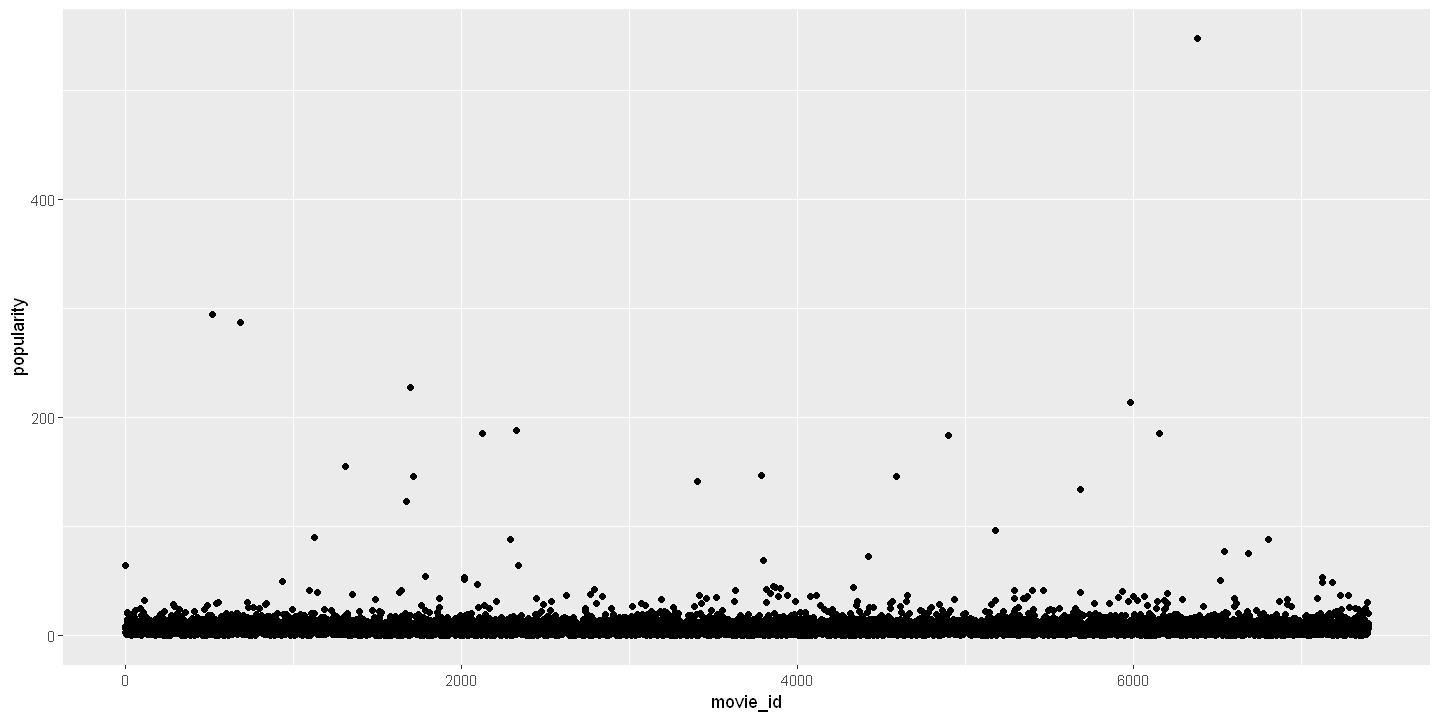

In [37]:
#popularity
ggplot(data=movies_ff) +
  geom_point(aes(x=movie_id , y=popularity))

Warning message:
"Removed 123 rows containing non-finite values (stat_density)."


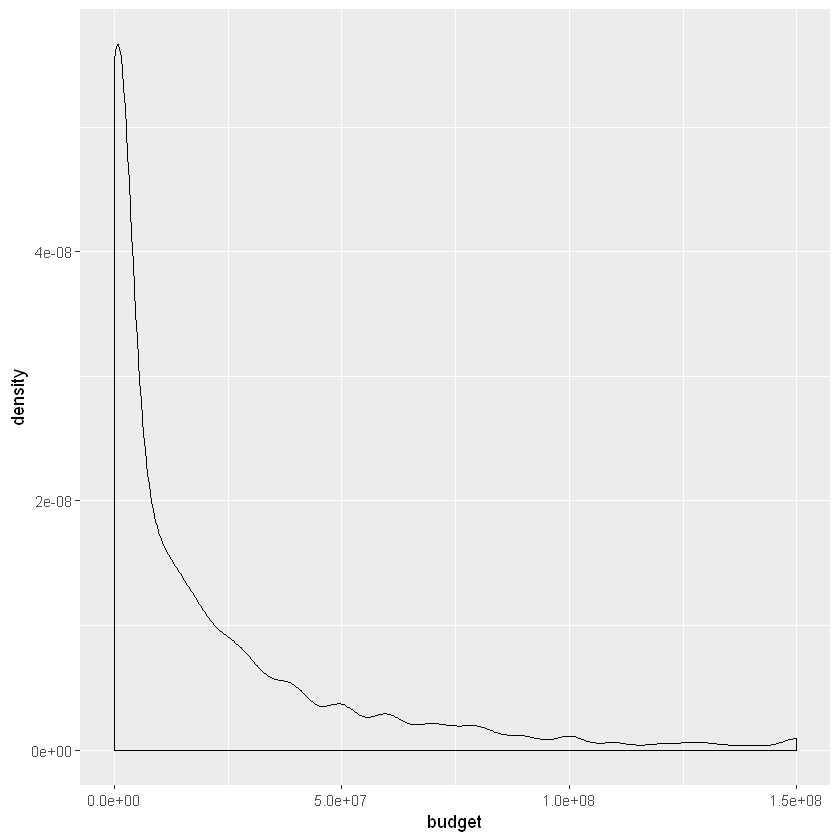

In [18]:
#budget
ggplot(data=movies_ff) +
    geom_density(aes(x = budget)) + xlim(0,150000000)

Warning message:
"Removed 4443 rows containing non-finite values (stat_density)."


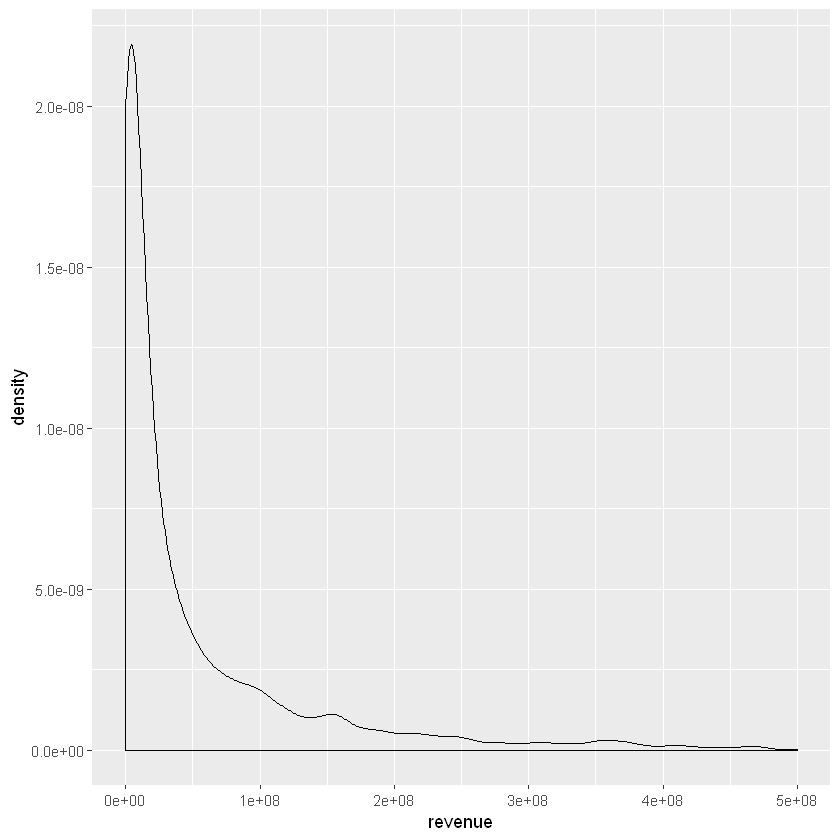

In [47]:
#revenue
ggplot(data=movies_ff) +
    geom_density(aes(x = revenue))  + xlim(0,500000000)

Warning message:
"Removed 5 rows containing missing values (geom_point)."


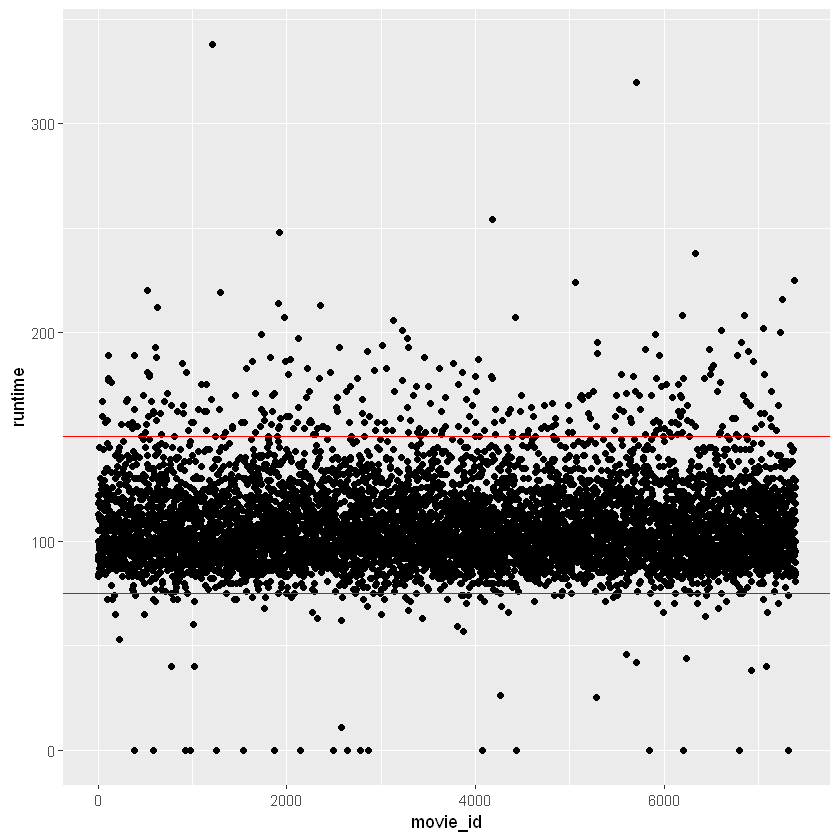

In [57]:
#runtime
ggplot(data=movies_ff) +
  geom_point(aes(x=movie_id , y=runtime)) + geom_hline(yintercept = 75,color="red") + geom_hline(yintercept = 150,color="red")


Warning message:
"Removed 26 rows containing non-finite values (stat_density)."


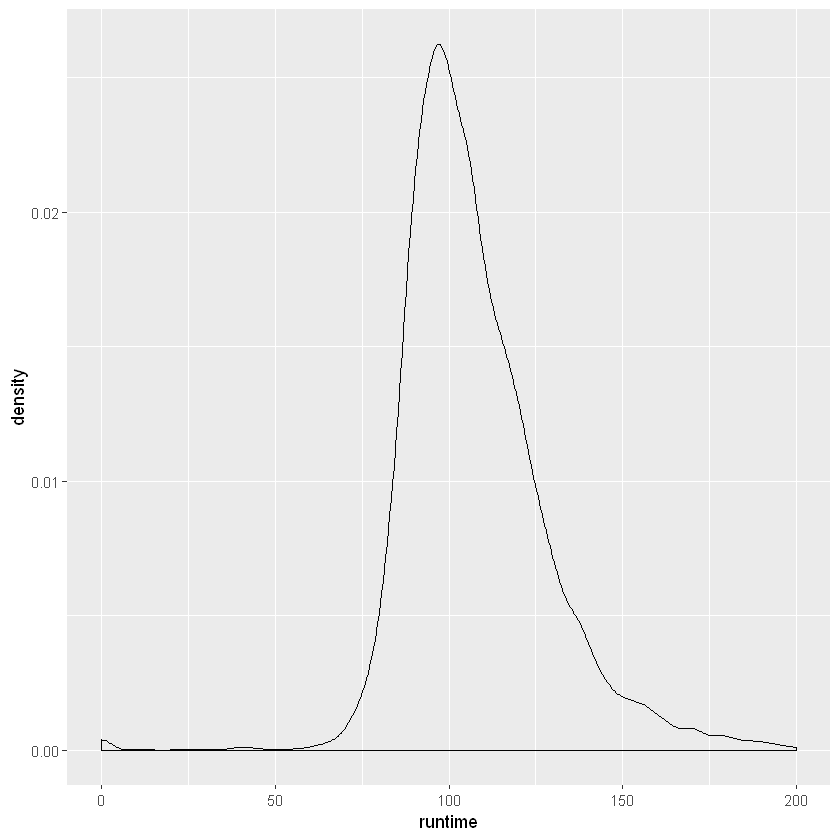

In [23]:
#runtime
ggplot(data=movies_ff) +
    geom_density(aes(x = runtime)) + xlim(0,200)

Selecting by n


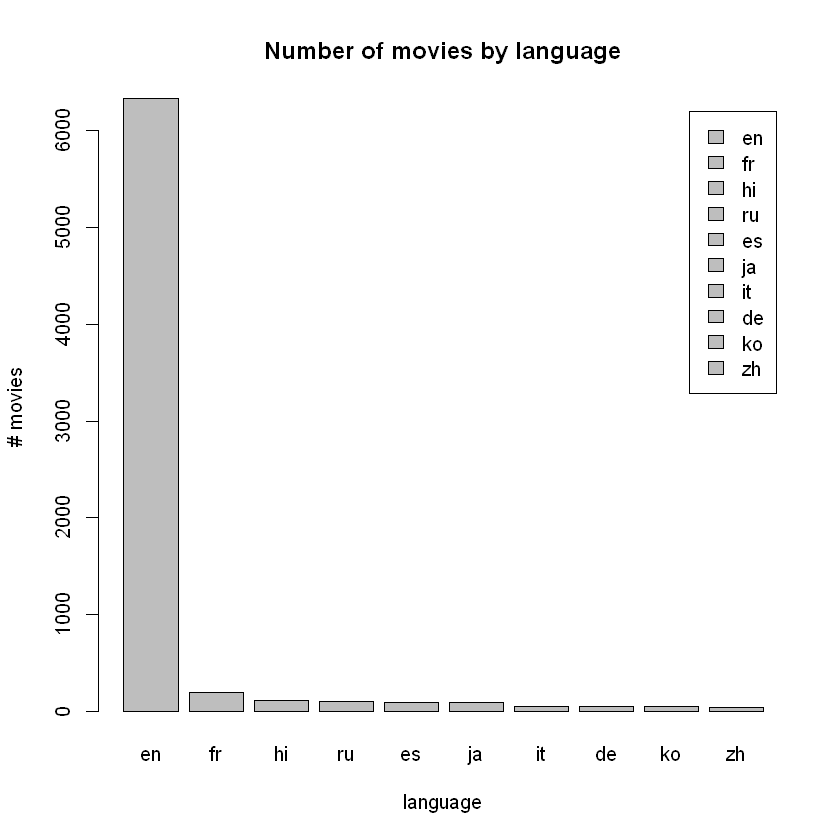

In [33]:
#language
lang_count <- movies_ff %>% group_by(original_language) %>% summarise(n=n()) %>% arrange(desc(n)) %>% top_n(10)
barplot(lang_count$n,main="Number of movies by language",legend.text = lang_count[[1]], names.arg = lang_count[[1]] ,xlab="language",ylab="# movies")

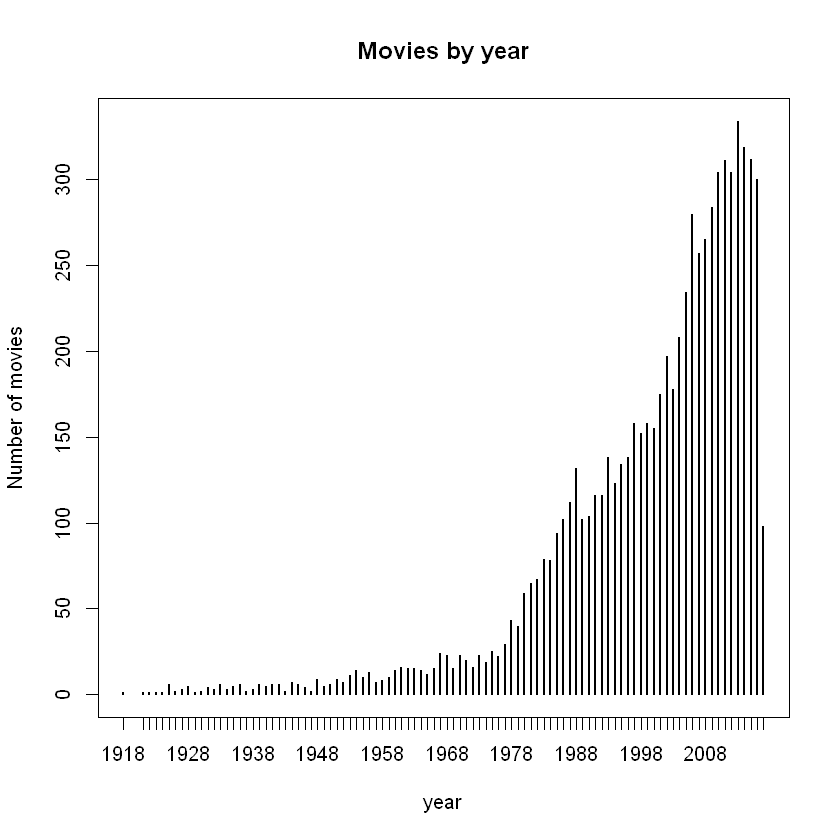

In [71]:
plot(table(year(movies_ff$release_date)),ylab="Number of movies",xlab="year",main="Movies by year")

In [32]:
## explore data for all arguments
exploreData(data=data.frame(movies_ff), dir="all_args_exploration")

  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  all_args_exploration\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

# 2.3 Correlation Matrix

In [8]:
install.packages("Hmisc")

Installing package into 'C:/Users/michs/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'Hmisc' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\michs\AppData\Local\Temp\RtmpeEkpKz\downloaded_packages


In [ ]:
library(Hmisc)

In [11]:
##### Check all variables are numeric ####
num_movies <- movies_ff[, sapply(movies_ff, is.numeric)]
head(num_movies)

movie_id,budget,popularity,runtime,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
1,14000000,6.575393,93,12314651,1,0,1,1,4,...,0,0,0,0,0,0,0,0,0,0
2,40000000,8.248895,113,95149435,1,0,1,1,4,...,0,0,0,0,0,0,3,0,0,1
3,3300000,64.299990,105,13092000,1,1,1,1,12,...,0,1,0,0,0,0,2,0,0,0
4,1200000,3.174936,122,16000000,0,1,1,0,7,...,0,0,0,0,0,0,0,0,0,0
5,0,1.148070,118,3923970,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8000000,0.743274,83,3261638,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
cor_res <- cor(num_movies, use ="pairwise.complete.obs",method="s")

Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the standard deviation is zero"
Warning message in cor(num_movies, use = "pairwise.complete.obs", method = "s"):
"the st

In [14]:
head(cor_res)

,movie_id,budget,popularity,runtime,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
movie_id,1.0000000000,0.0009736131,0.005477086,0.002341803,0.009997652,0.001170905,0.004466673,0.004862132,-0.008193279,0.01012805,...,-0.005727583,-8.193342e-05,0.003404204,-0.004240663,-0.01086437,-0.01425605,-0.000443574,-0.02289685,0.01435770,-0.009913564
budget,0.0009736131,1.0000000000,0.517639218,0.250502521,0.691007848,0.243950993,0.211737710,0.020959371,0.298541124,0.28302850,...,0.036589693,1.755995e-01,0.315041130,0.139602278,0.08616299,0.01364380,0.396343510,0.13053200,0.08256478,0.049253239
popularity,0.0054770856,0.5176392179,1.000000000,0.171363671,0.594538732,0.258408834,0.210234301,0.028406920,0.348489699,0.43147356,...,0.065173132,1.774725e-01,0.294492671,0.126272830,0.10216707,0.01419199,0.395866981,0.13821703,0.07644792,0.060167155
runtime,0.0023418029,0.2505025212,0.171363671,1.000000000,0.261910598,-0.117635059,0.043810470,0.014082759,0.006435861,0.14320100,...,0.001225895,7.042466e-02,0.169646772,0.069858973,0.04849778,-0.01132805,0.126761948,0.07748747,0.00525580,0.026717987
revenue,0.0099976524,0.6910078479,0.594538732,0.261910598,1.000000000,0.221077560,0.191729626,0.027253296,0.333861394,0.33226715,...,0.032005853,1.628297e-01,0.317688650,0.126197294,0.05829747,0.03135544,0.387482082,0.14117393,0.07706105,0.099745155
sw_lang_en,0.0011709051,0.2439509928,0.258408834,-0.117635059,0.221077560,1.000000000,0.035833839,0.017001119,0.399816033,0.16898117,...,0.046737688,6.850151e-02,0.203880661,0.110337186,0.08101905,0.01057666,0.291199051,0.08149105,0.02808414,0.050204337


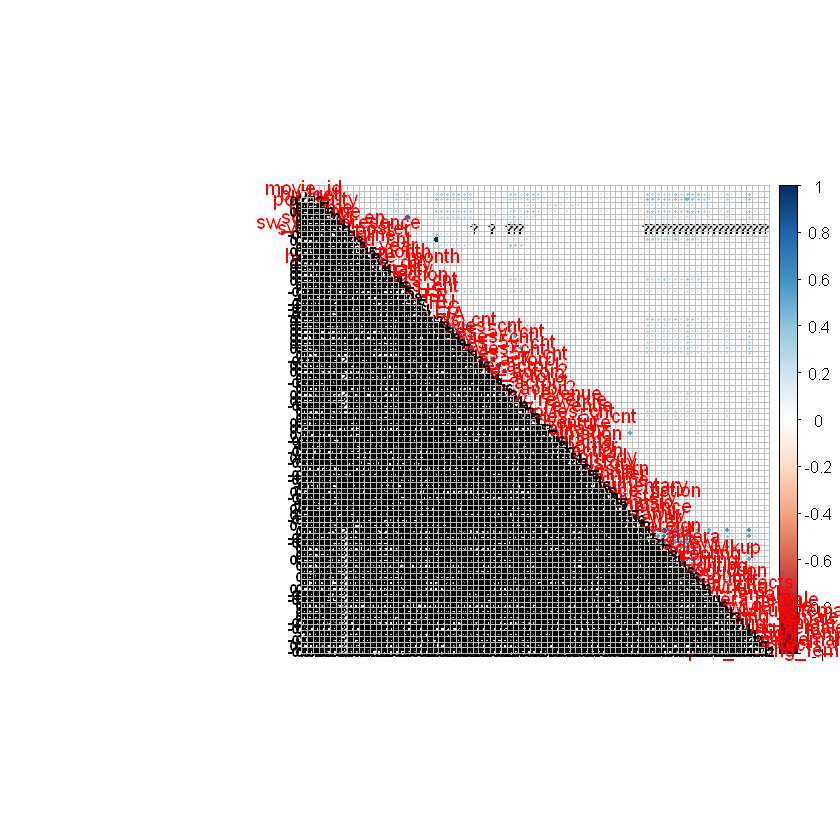

In [17]:
corrplot.mixed(cor_res, lower.col = "black", number.cex = .7, tl.srt = 90)

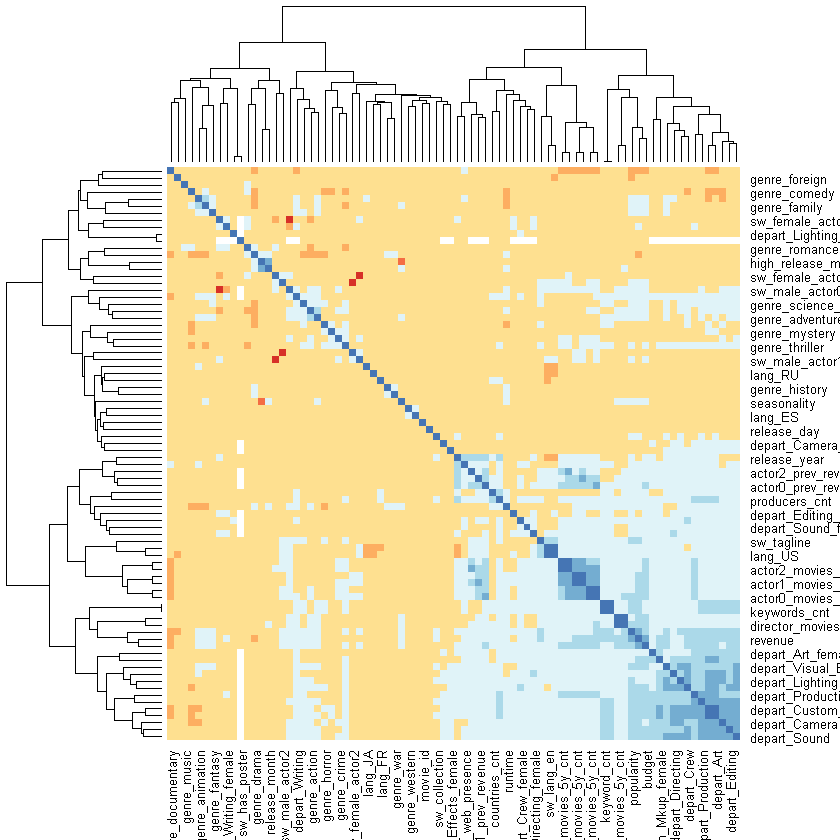

In [16]:
heatmap(cor_res,symm = T,cexCol = 0.8, cexRow = 0.8, col=brewer.pal(n=8, name="RdYlBu"))

In [67]:
###tomas in class#####??????????????????????????###########################33

nm <- names(movies_ff[,2:84])
for(i in nm) {
    rw <- NULL
    for(j in nm) {
        rw <- cbind(rw,cor.test(x=movies_ff[[i]],y=movies_ff[[j]],method="spearman")$estimate)
    }
    res <- rbind(res,rw)
}
row.names(res) <- nm
colnames(res) <- nm
res

Warning message in cor.test.default(x = movies_ff[[i]], y = movies_ff[[j]], method = "spearman"):
"Cannot compute exact p-value with ties"


ERROR: Error in cor.test.default(x = movies_ff[[i]], y = movies_ff[[j]], method = "spearman"): 'y' must be a numeric vector


# 2.4 revenue analysis

In [25]:
##### explore all depandent variables in revenue ########
exploreData(data=data.frame(movies_ff),y="revenue",dir="all_args_vs_revenue")

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4384 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4531 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.04"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.04"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.04"
Warning mess

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5310 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5534 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message:
"Removed 5621 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.115"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  2.1936e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.115"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.115

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.595"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.6396e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.595"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.595

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.165"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.5645e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.165"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.165

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 0.855"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1.145"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 0.855"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1.145"
Warning me

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.07"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.4018e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.07"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.07"
Wa

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0036"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"at  -0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"radius  0.0676"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"all data on boundary of neighborhood. make span bigger"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.26"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"zero-width neighborhood. make span bigger"
Warning message:
"Computation failed in `stat_smooth()`:
NA/NaN/Inf i

  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 2"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 1"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  0"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 2"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 1"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4397 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -0.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.06"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.4247e-016"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at -0.06"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.06"
Wa

  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |                                                                      |   0%

Warning message:
"Removed 4382 rows containing non-finite values (stat_smooth)."


  |===================================================================== |  99%

Warning message in system(cmd, intern = intern, wait = wait | intern, show.output.on.console = wait, :
"running command 'C:\WINDOWS\system32\cmd.exe /c explorer  report\report.html' had status 1"


character(0)
attr(,"status")
[1] 1

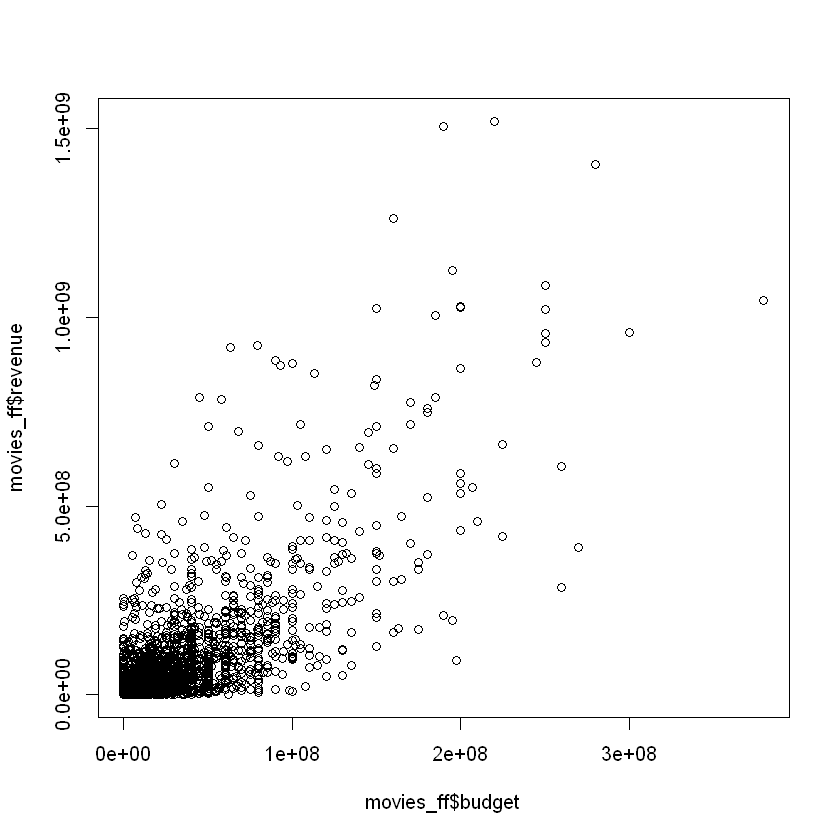

In [49]:

plot(movies_ff$revenue ~ movies_ff$budget)

In [58]:
movies_ff <- movies_ff %>% 
    mutate(orig_lang2=ifelse(original_language %in% c("en","fr","in","ru","es","ja"),original_language,'other'))

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."


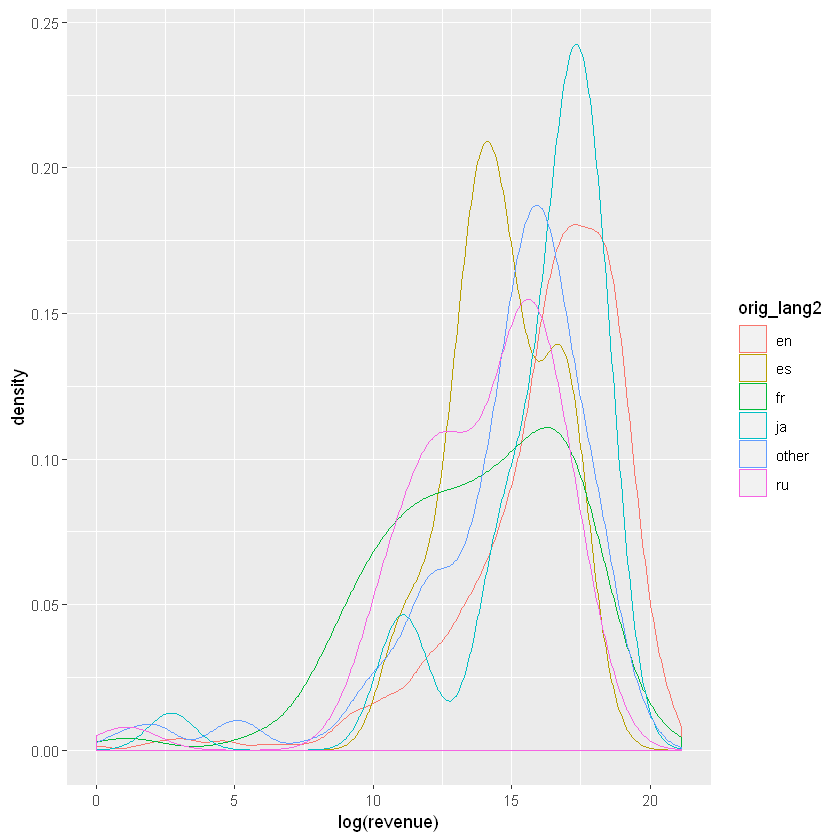

In [59]:
ggplot(data=movies_ff) +
    geom_density(aes(log(revenue), group=orig_lang2, color=orig_lang2))

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


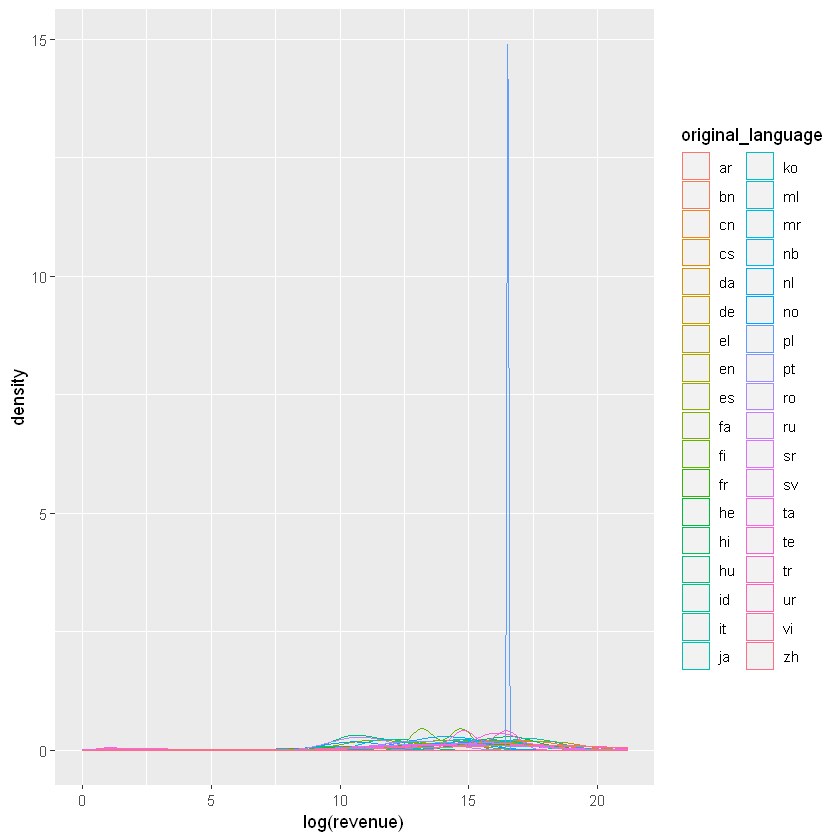

In [60]:
ggplot(data=movies_ff) +
    geom_density(aes(log(revenue), group=original_language, color=original_language ))

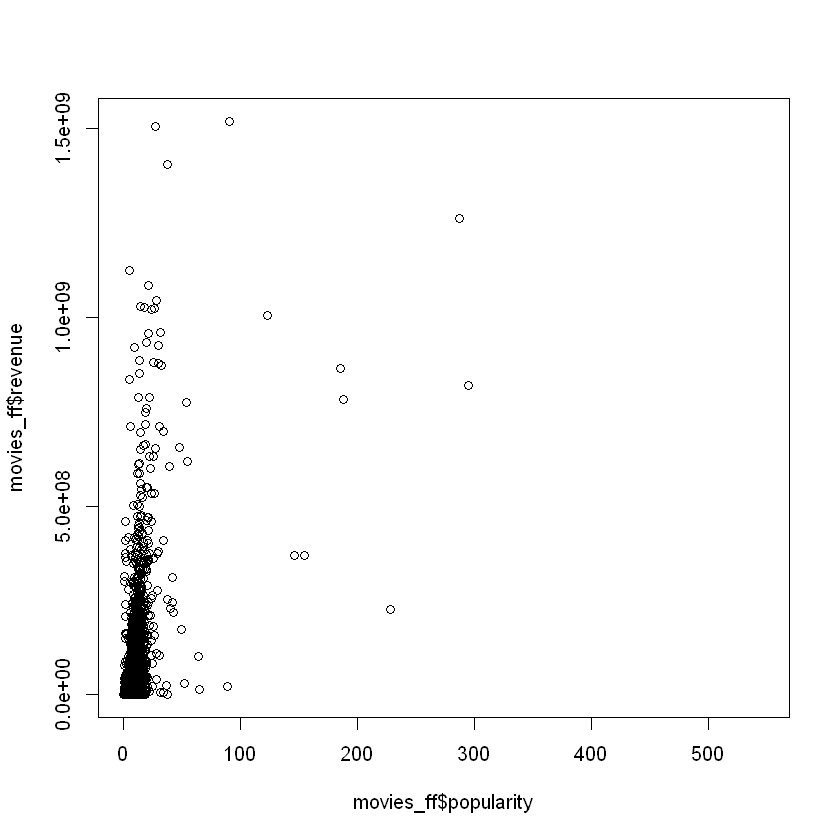

In [62]:
plot(movies_ff$revenue ~ movies_ff$popularity)

NULL


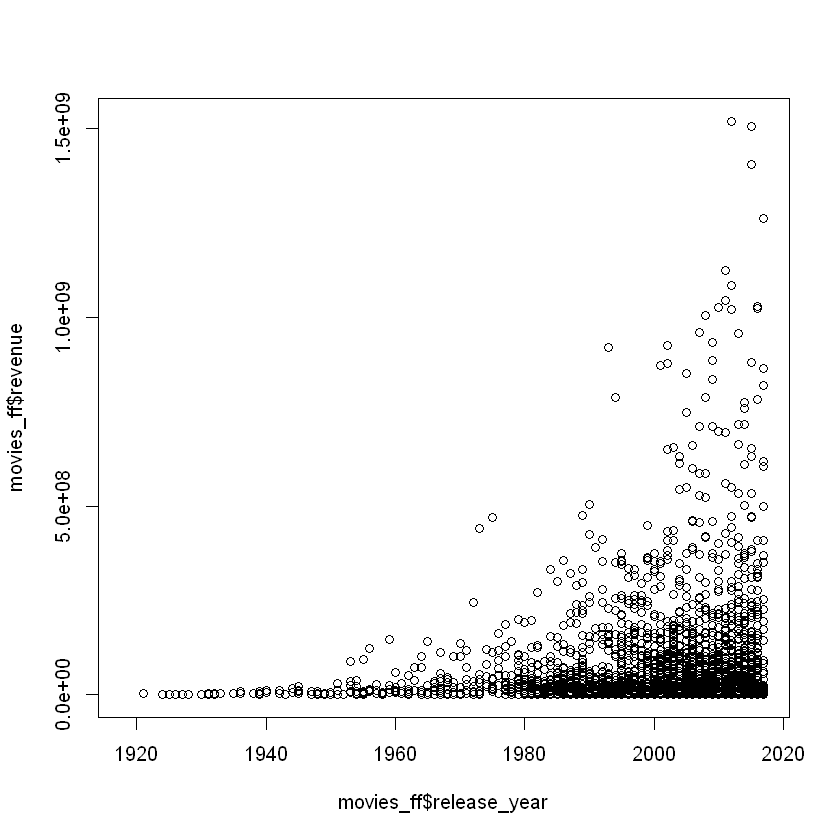

In [68]:
plot(movies_ff$revenue ~ movies_ff$release_year)

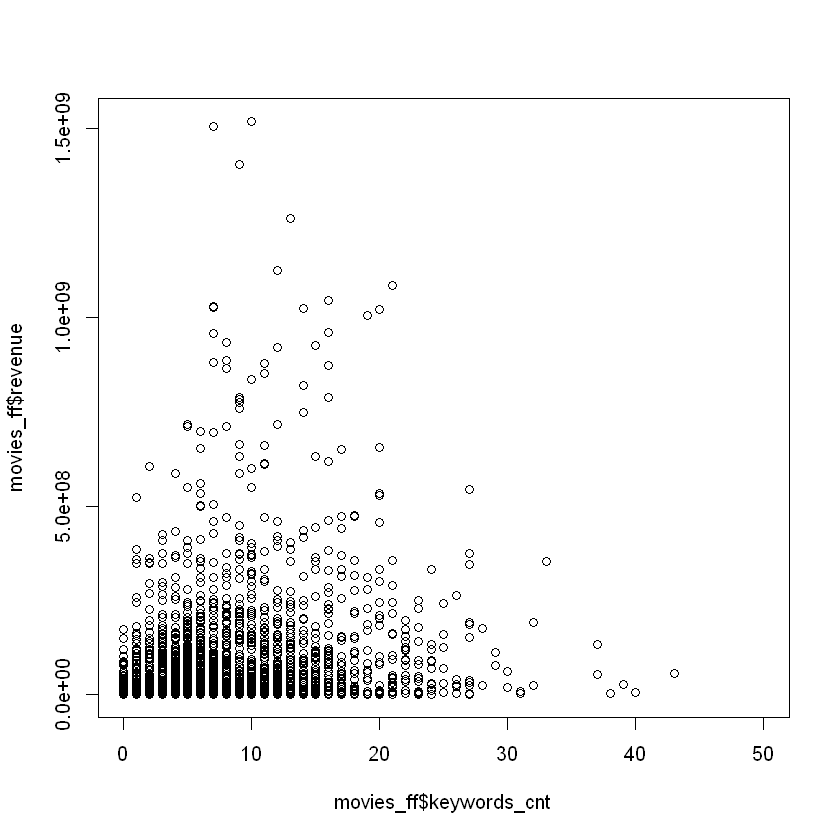

In [70]:
plot(movies_ff$revenue ~ movies_ff$keywords_cnt, xlim=c(0,50))

# 2.5 - outliers

In [21]:
outliers <- outlierMatrix(movies_ff)

In [22]:
head(outliers)

movie_id,budget,popularity,runtime,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(movies_ff,threshold=1.5))

movie_id,budget,popularity,runtime,revenue,sw_lang_en,sw_web_presence,sw_has_poster,sw_tagline,keyword_cnt,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


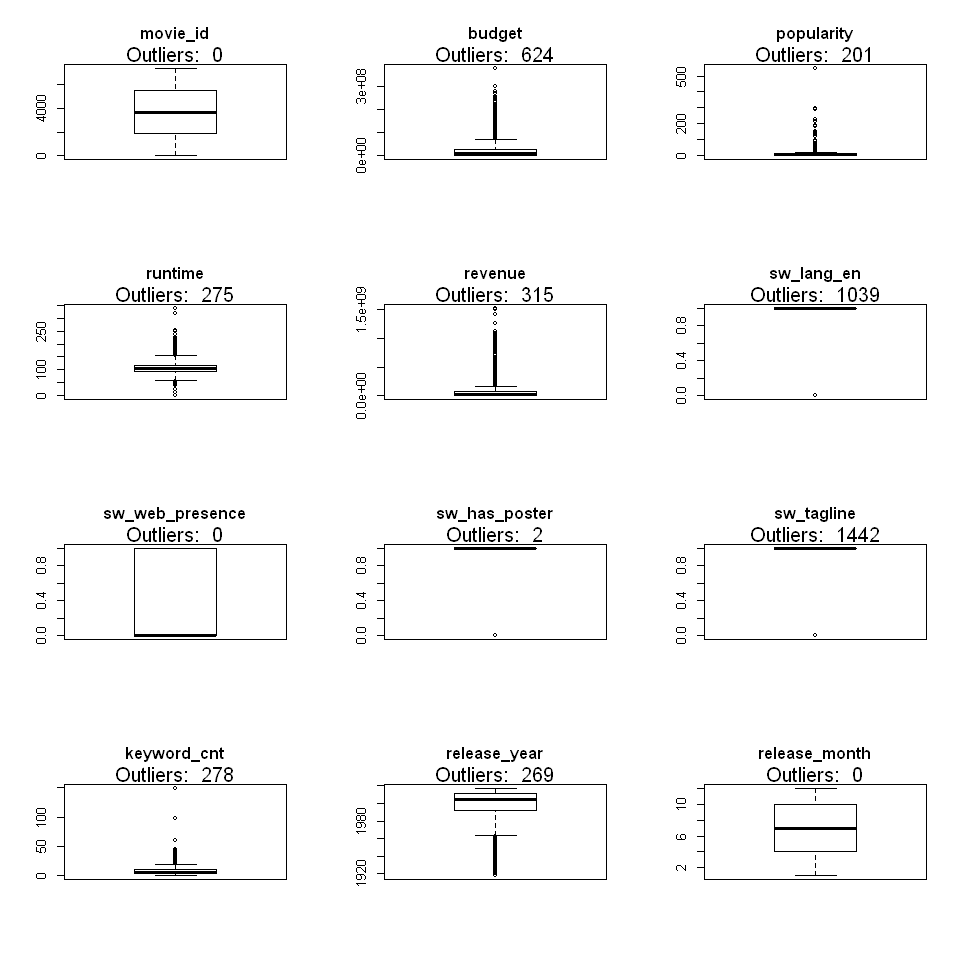

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


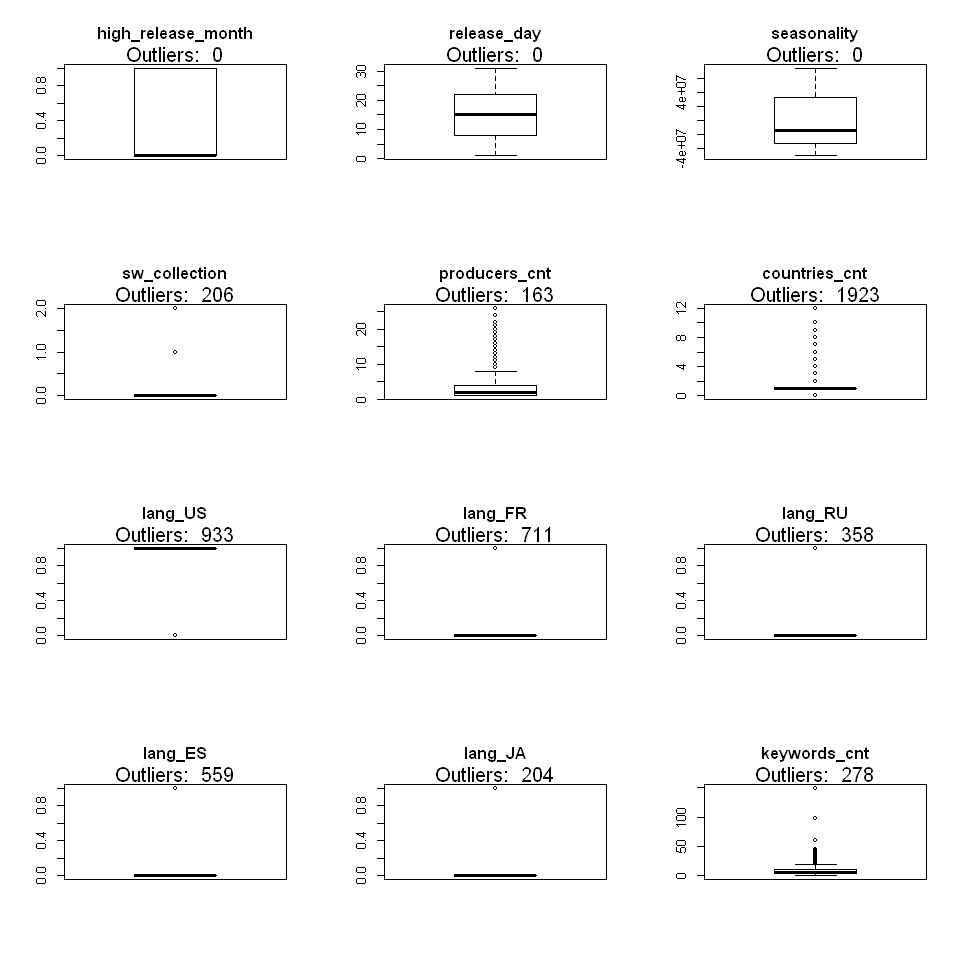

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"
Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"


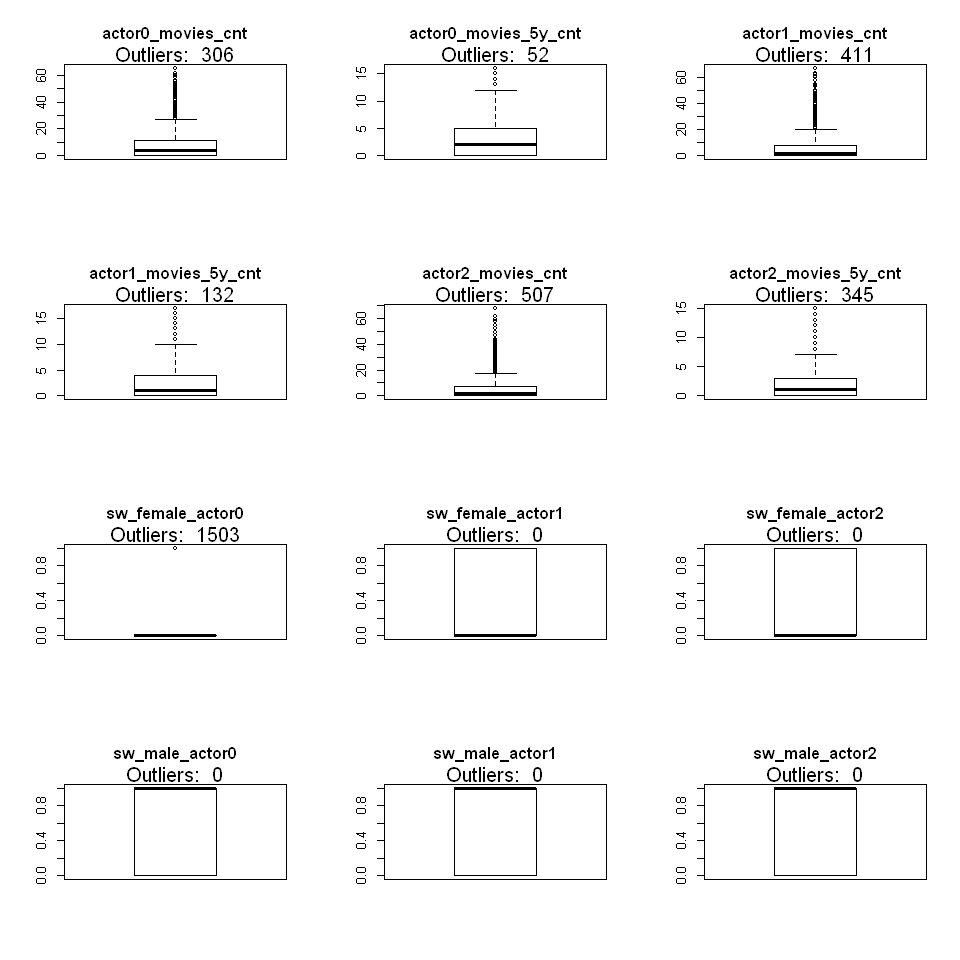

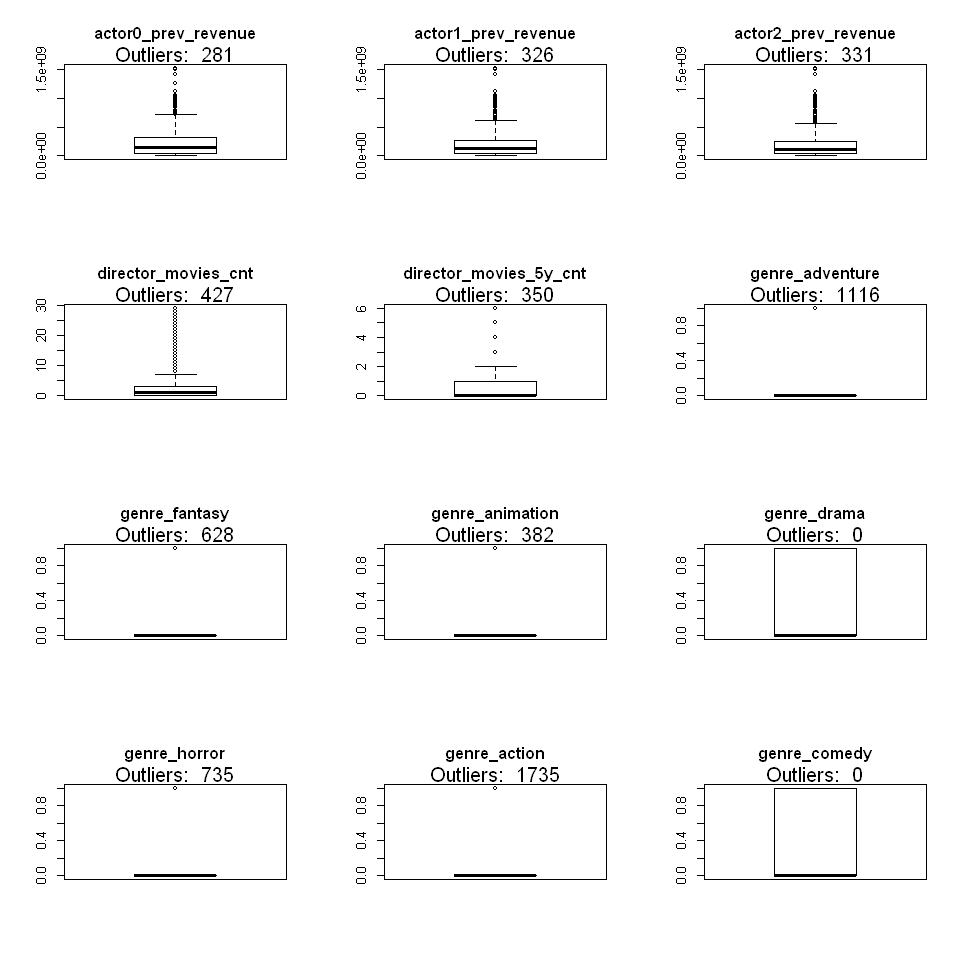

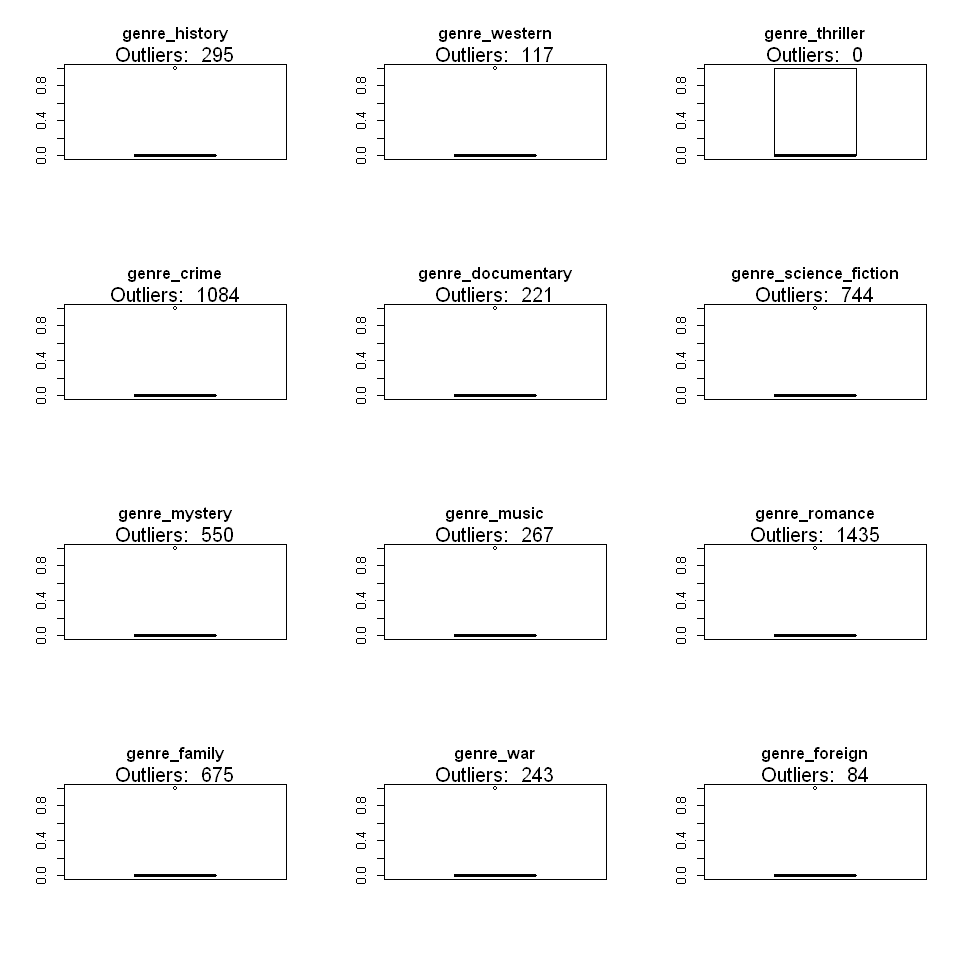

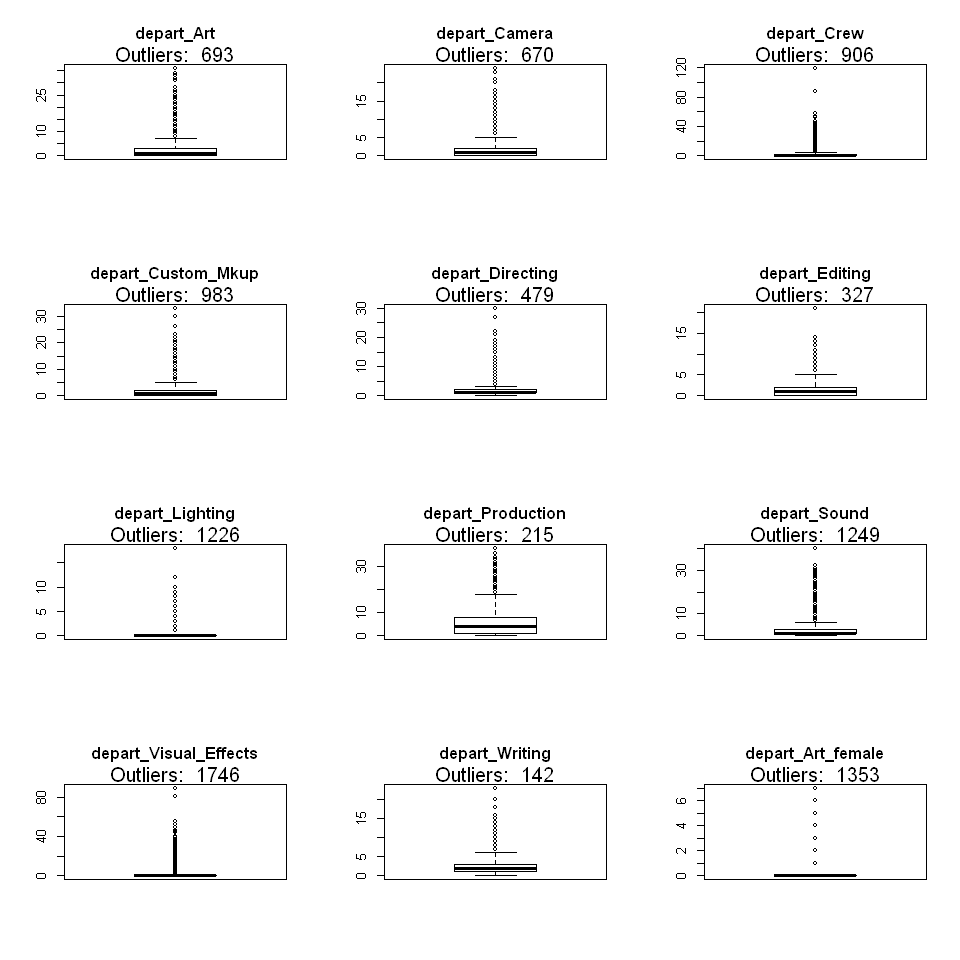

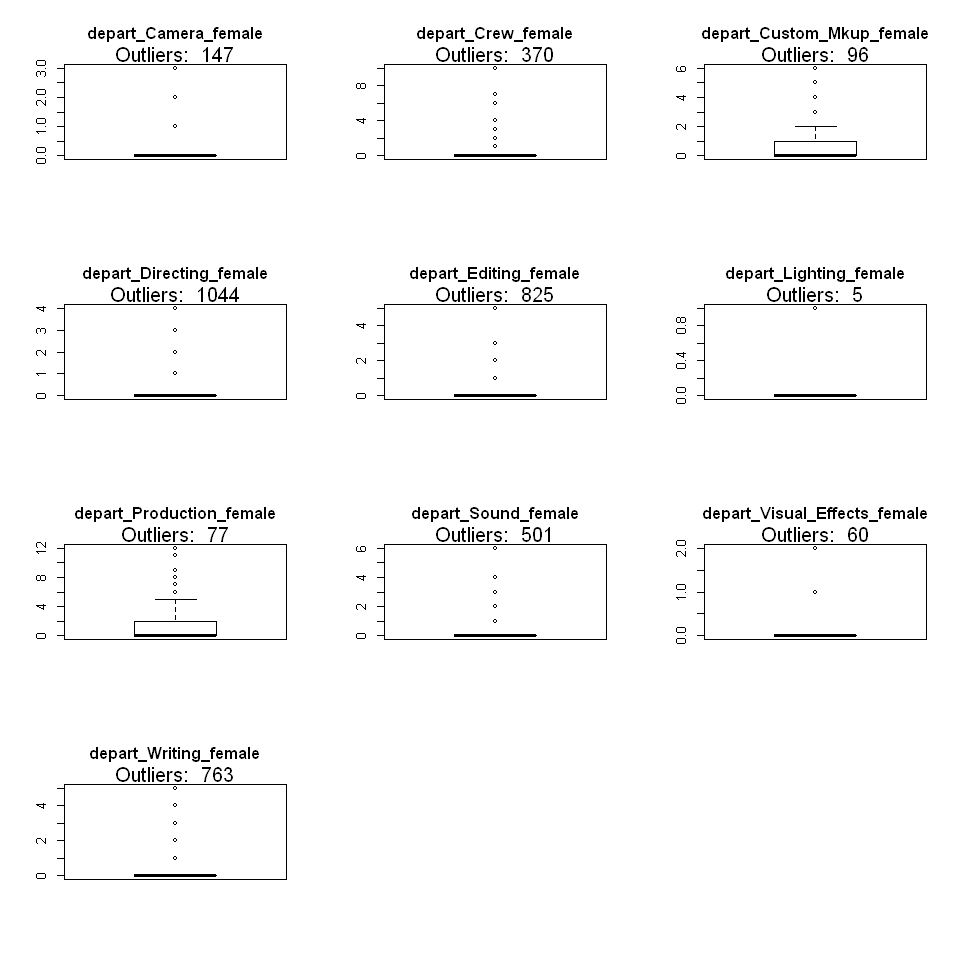

In [26]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(num_movies[,1:82])) {
    outlier_values <- boxplot.stats(num_movies[,v])$out
    boxplot(movies_ff[[v]],main=v)
    mtext(paste("Outliers: ", paste(length(outlier_values), collapse=", ")), cex=1)
}
par(mfrow=c(1,1))

In [58]:
dim(movies_ff)

[1] 7375   85

# 2.6 - Missings

In [27]:
getMissingness(movies_ff)

[[1]]
                   var na.count rate
1              revenue     4382 59.4
2  actor2_prev_revenue     3423 46.4
3  actor1_prev_revenue     3201 43.4
4  actor0_prev_revenue     2752 37.3
5     sw_female_actor0      934 12.7
6       sw_male_actor0      934 12.7
7     sw_female_actor2      788 10.7
8       sw_male_actor2      788 10.7
9     sw_female_actor1      782 10.6
10      sw_male_actor1      782 10.6

[[2]]
[1] "This dataset has 1154 (15.6%) complete rows. Original data has 7375 rows."



var,na.count,rate
revenue,4382,59.4
actor2_prev_revenue,3423,46.4
actor1_prev_revenue,3201,43.4
actor0_prev_revenue,2752,37.3
sw_female_actor0,934,12.7
sw_male_actor0,934,12.7
sw_female_actor2,788,10.7
sw_male_actor2,788,10.7
sw_female_actor1,782,10.6
sw_male_actor1,782,10.6


In [28]:
movies_missings <- movies_ff
for(i in names(movies_ff)) {
    movies_missings[,i] <- ifelse(is.na(movies_missings[,i])==T,1,0)
}

In [29]:
movies_missings

movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Warning message in brewer.pal(n = ncol(movies_ff), name = "RdYlBu"):
"n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
"


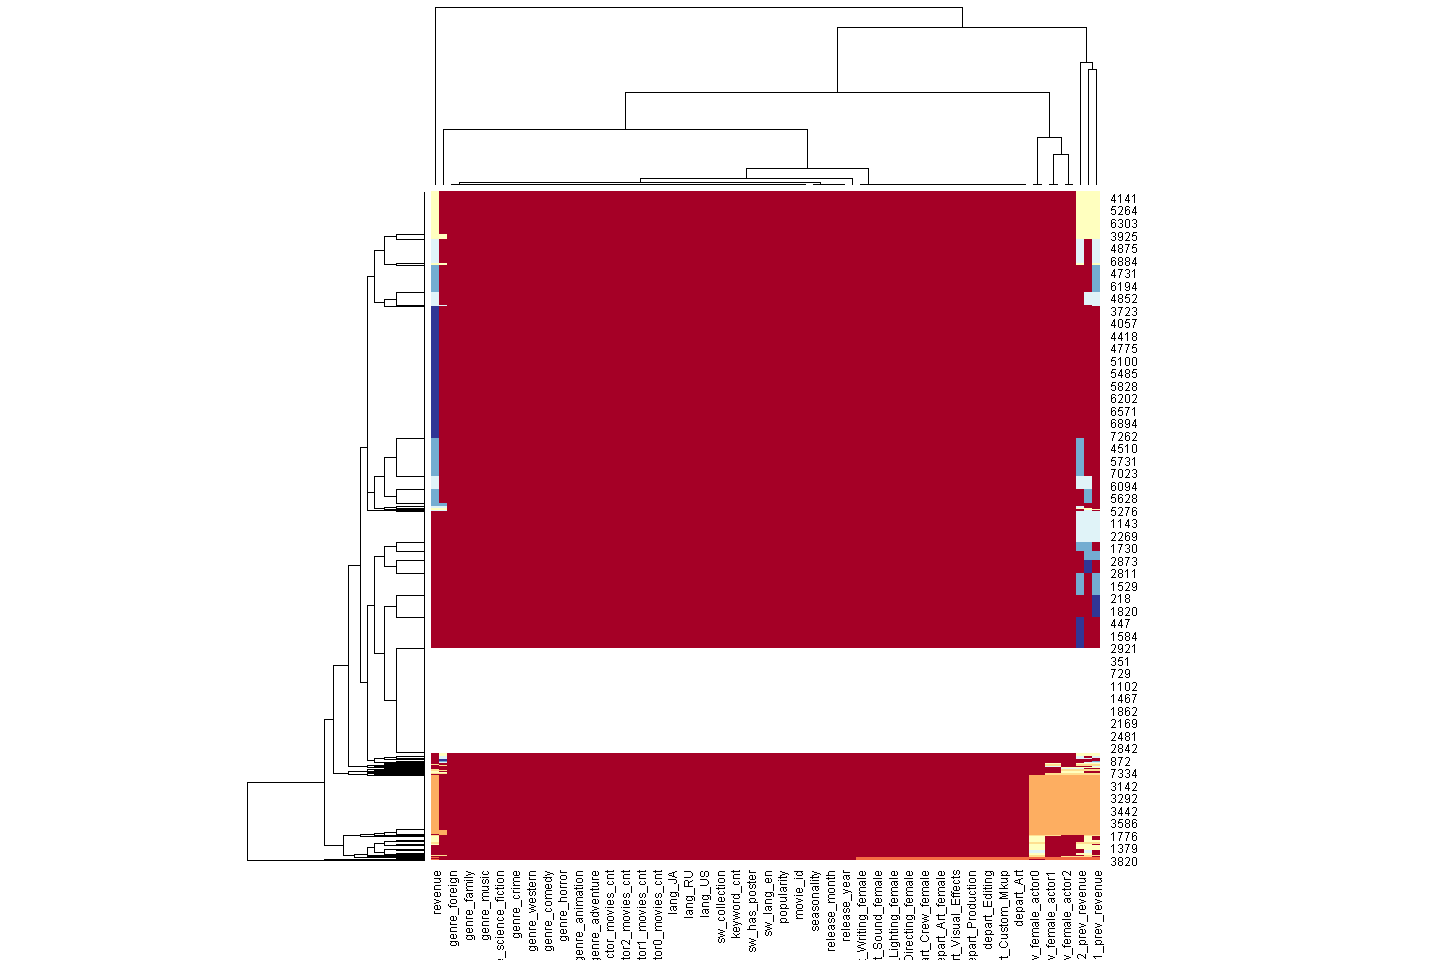

In [40]:
heatmap(as.matrix(movies_missings),cexCol = 0.7, cexRow = 0.7, col=brewer.pal(n=ncol(movies_ff), name="RdYlBu"))

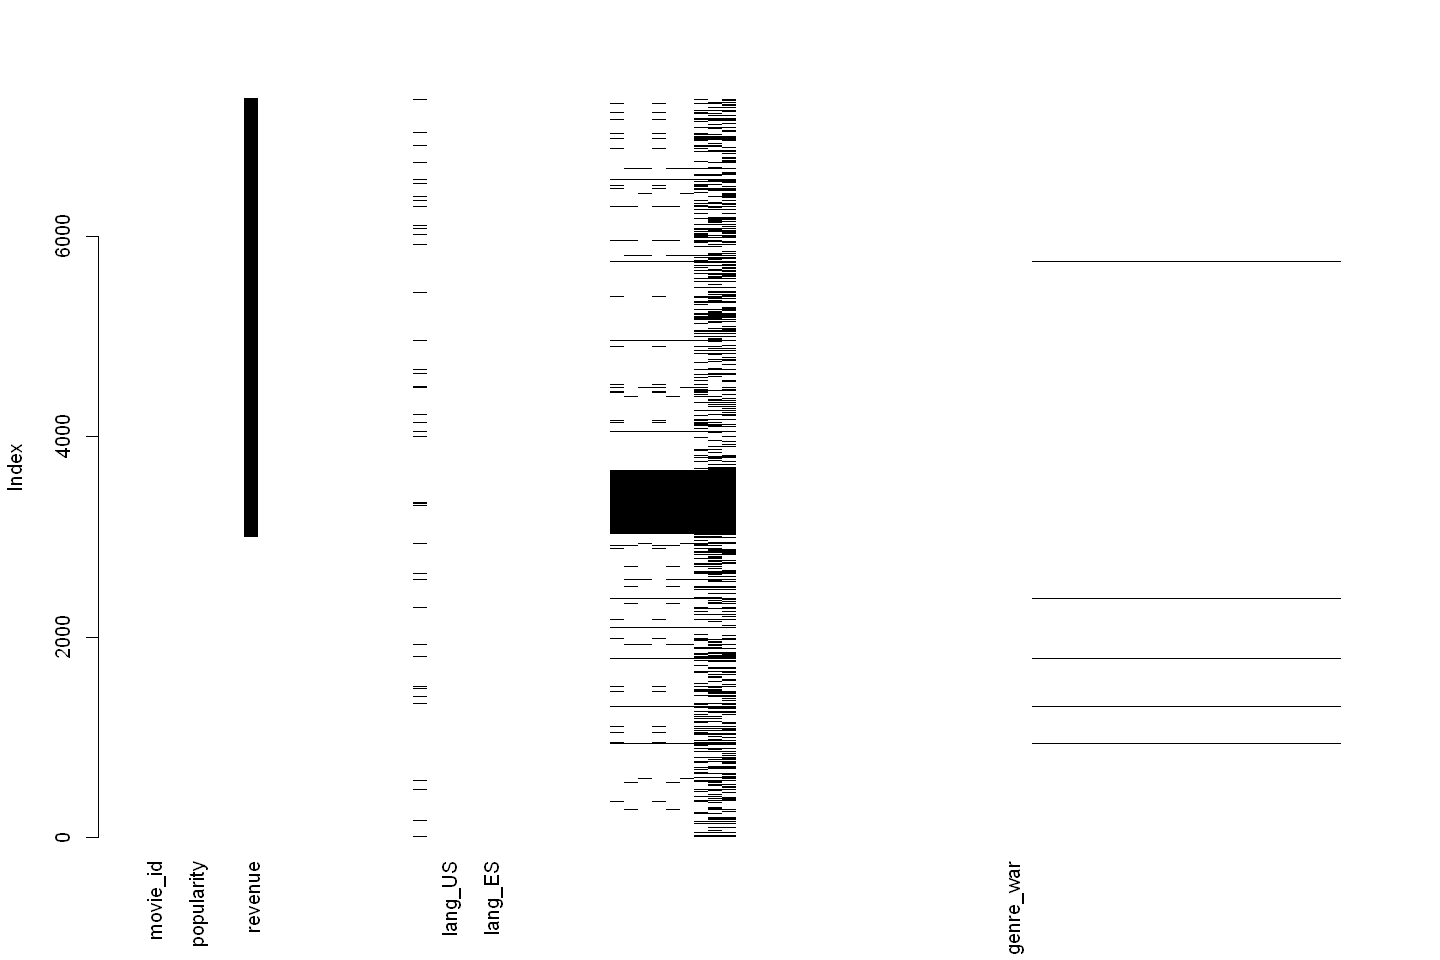

In [39]:
matrixplot(as.matrix(movies_missings))